In [71]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
import copy
from scipy.signal import butter, filtfilt
from scipy.signal import czt
import csv
import pywt


In [72]:
#read data
file_path = './FMCW Radar/Rawdata/Rawdata_1.csv'
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]


In [73]:
T_c = 91.72 * (1e-6)   # Chirp time
f_start = 60.25*(1e9)  # Hz
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
RANGE_RESOLUTION=4 # 4cm
MAX_RANGE=1100#11 m = 1100 cm
speed_of_light = 299792458

In [74]:
print(len(raw_data_channel_0))
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP*2] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP*2)]
first_chirps_of_frame = [chirps[j] for j in range(0, len(chirps), 1)]
print(np.array(first_chirps_of_frame).shape)


3072000
(6000, 512)


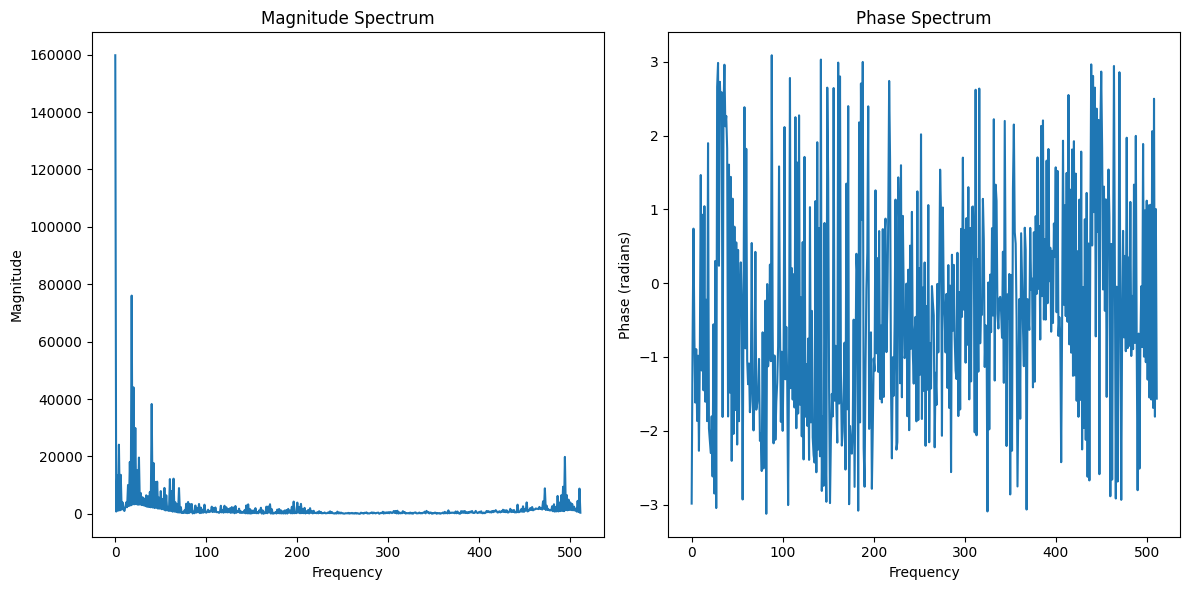

In [75]:
complex_range_profiles = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]
magnitudes = [np.abs(complex_range_profile) for complex_range_profile in complex_range_profiles]
angles = [np.angle(complex_range_profile) for complex_range_profile in complex_range_profiles]
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(magnitudes[0])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum')

plt.subplot(122)
plt.plot(angles[0])
plt.xlabel('Frequency')
plt.ylabel('Phase (radians)')
plt.title('Phase Spectrum')

plt.tight_layout()

In [76]:
# range-slow time matrix

range_slow_time_m_x_n = [np.fft.fft(first_chirp) for first_chirp in first_chirps_of_frame]


In [94]:
# calculate DC 
org_range_slow_time_m_x_n = copy.deepcopy(range_slow_time_m_x_n)
corrected_range_slow_time_m_x_n = np.empty(shape=np.array(range_slow_time_m_x_n).shape, dtype=complex)

range_bins=np.array(range_slow_time_m_x_n).shape[1]
DC_ranges=  np.empty(range_bins, dtype='object')
print("check ",range_bins," bin")
for r_th in range(0,range_bins):
    # print("check ",r_th,"th bin")
    range_bin_r_th =np.array(range_slow_time_m_x_n)[:,r_th]
    avg_re_I= np.mean(np.real(range_bin_r_th))
    avg_im_Q= np.mean(np.imag(range_bin_r_th))
    DC_ranges[r_th]=avg_re_I +  avg_im_Q*1j


check  512  bin


In [95]:
print(np.array(DC_ranges).shape)

(512,)


In [114]:
#DC correction
for i_th in range(0,range_bins):
    DC=DC_ranges[i_th]    
    corrected_range_slow_time_m_x_n[:,i_th] = np.array(range_slow_time_m_x_n)[:,i_th] -DC
    

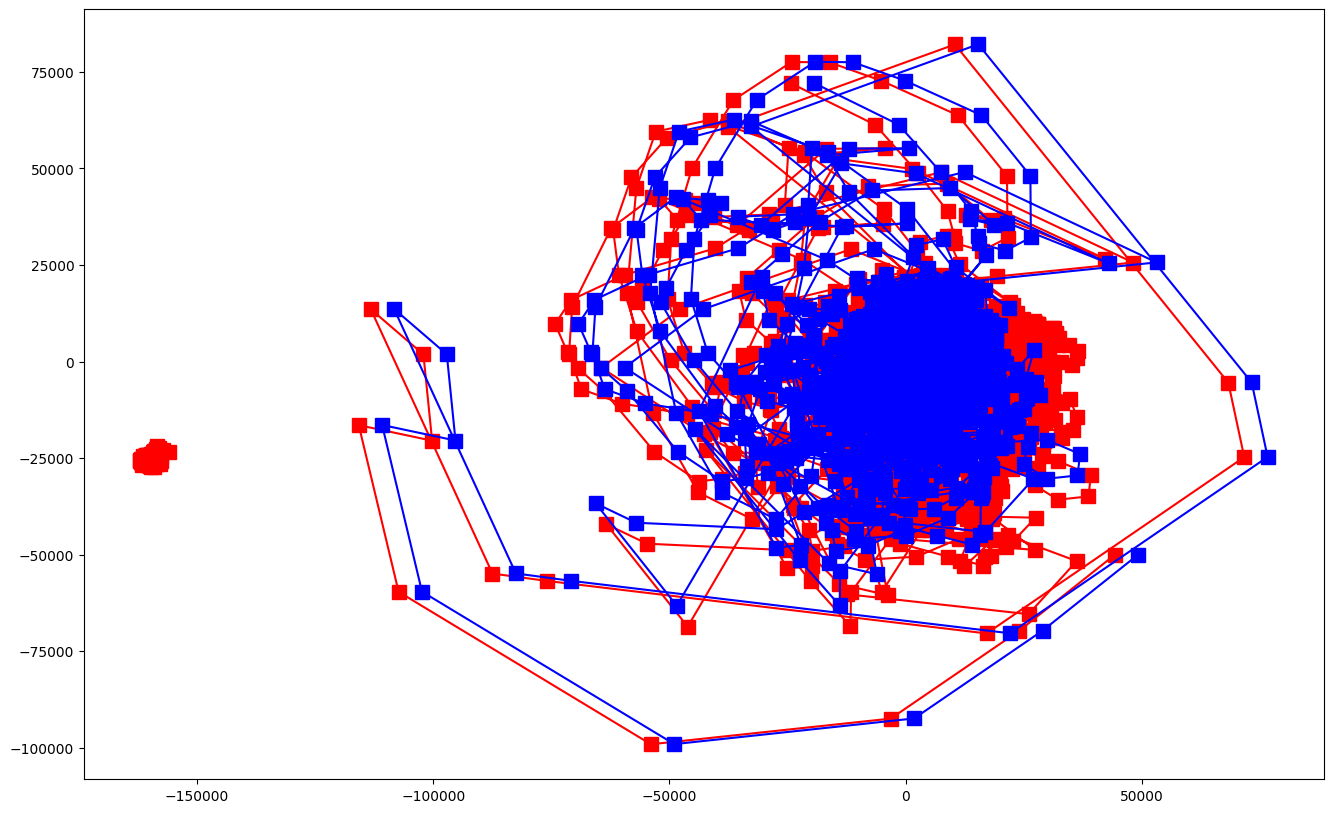

In [100]:
tmp_org_range_slow_time_m_x_n =org_range_slow_time_m_x_n[0:200]
DC_real_parts = [z.real for z in tmp_org_range_slow_time_m_x_n]
DC_imaginary_parts = [z.imag for z in tmp_org_range_slow_time_m_x_n]

tmp_range_slow_time_m_x_n =corrected_range_slow_time_m_x_n[0:200]
DC_corrected_real_parts = [sl.real for sl in tmp_range_slow_time_m_x_n]
DC_corrected_imaginary_parts = [sl.imag for sl in tmp_range_slow_time_m_x_n]



plt.figure(figsize=(16, 10))

plt.plot(DC_real_parts, DC_imaginary_parts, 'rs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_real_parts, DC_imaginary_parts, color='red')

plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, 'bs-', markeredgewidth=1, markersize=10,linewidth=0)
plt.plot(DC_corrected_real_parts, DC_corrected_imaginary_parts, color='blue')
plt.show()


In [112]:
#test MTI
delayed_signal = np.zeros_like(first_chirps_of_frame)
mti_signal = np.zeros_like(first_chirps_of_frame)
for pulse_idx in range(len(first_chirps_of_frame)):    
    current_pulse = first_chirps_of_frame[pulse_idx]
    if pulse_idx>0:
        mti_signal[pulse_idx] = current_pulse -delayed_signal[pulse_idx-1]
    delayed_signal[pulse_idx]= current_pulse

mti_ffts = [np.fft.fft(mti) for mti in mti_signal]
mti_ffts_mags = [np.abs(mti_fft) for mti_fft in mti_ffts]

In [ ]:
new_corrected_range_slow_time_m_x_n = np.zeros_like(corrected_range_slow_time_m_x_n)
for i_th in range(0,range_bins):
    DC=DC_ranges[i_th]    
    new_corrected_range_slow_time_m_x_n[:,i_th] = np.array(corrected_range_slow_time_m_x_n)[:,i_th] -DC
new_magnitude_corrected_ffts = [np.abs(new_corrected_fft) for new_corrected_fft in new_corrected_range_slow_time_m_x_n]


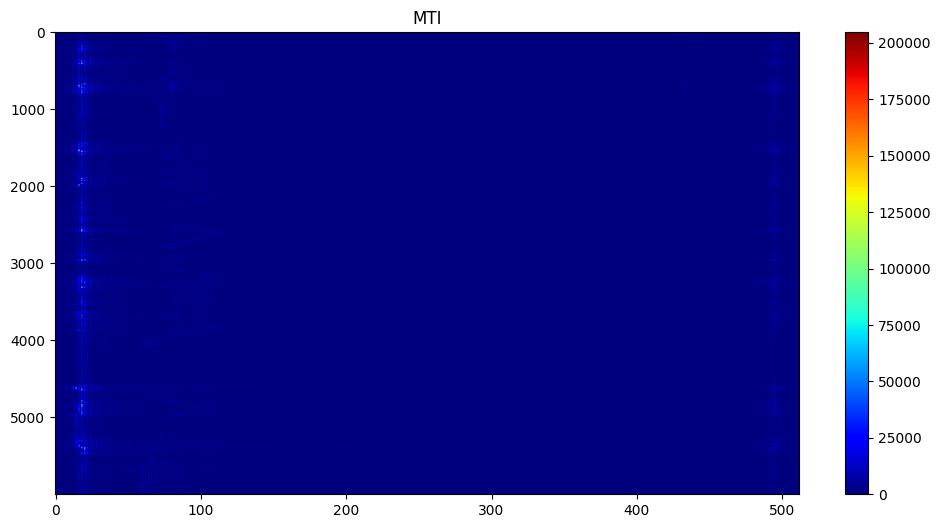

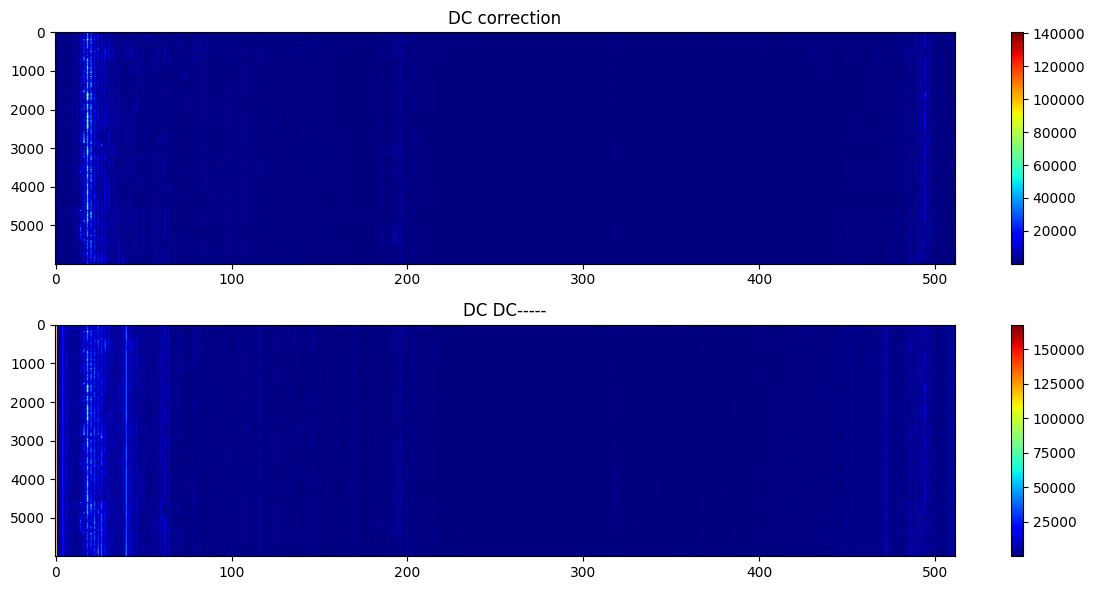

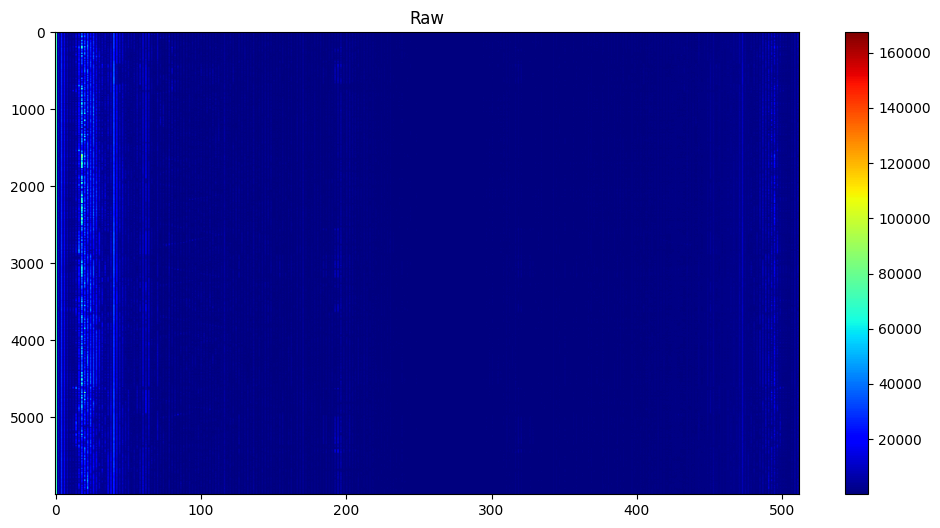

In [128]:
magnitude_corrected_ffts = [np.abs(corrected_fft) for corrected_fft in corrected_range_slow_time_m_x_n]
magnitude_org_ffts = [np.abs(org) for org in org_range_slow_time_m_x_n]
plt.figure(figsize=(12, 6))
plt.imshow(mti_ffts_mags, cmap='jet', aspect='auto')
plt.colorbar()
plt.title("MTI")
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.imshow(magnitude_corrected_ffts, cmap='jet', aspect='auto')
plt.colorbar()
plt.title("DC correction")

plt.subplot(2,1,2)
plt.imshow(new_magnitude_corrected_ffts, cmap='jet', aspect='auto')
plt.title("DC DC-----")
plt.colorbar()

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.imshow(magnitude_org_ffts, cmap='jet', aspect='auto')
plt.title("Raw")
plt.colorbar()
plt.show()

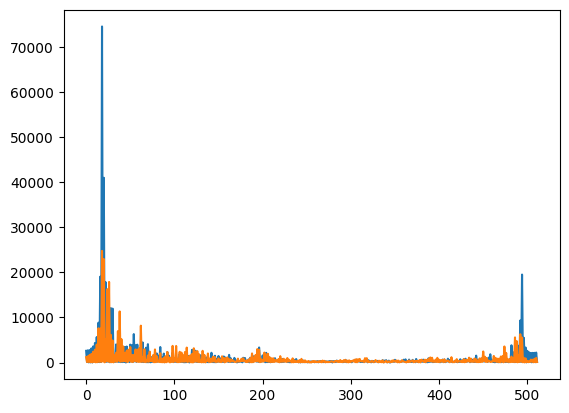

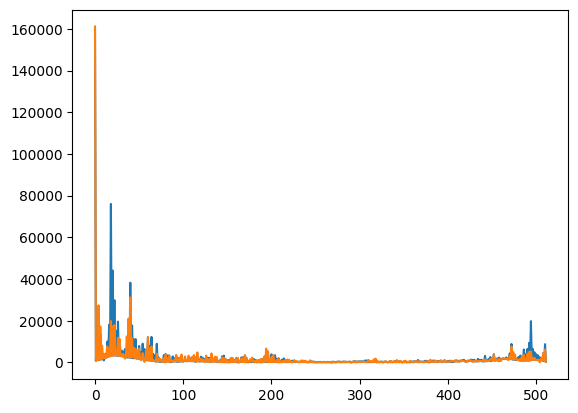

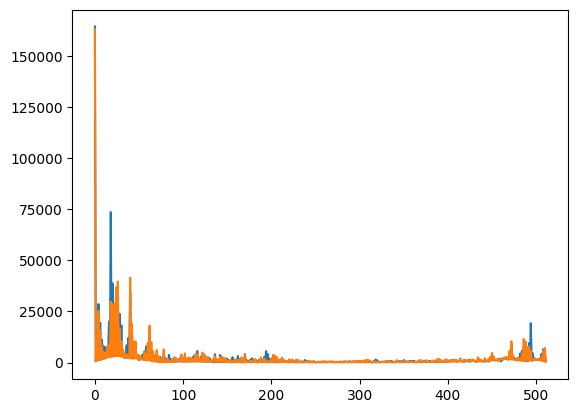

In [122]:
plt.plot(magnitude_corrected_ffts[0])
plt.plot(magnitude_corrected_ffts[-1])
plt.show()
plt.plot(magnitude_org_ffts[0])
plt.plot(magnitude_org_ffts[-1])
plt.show()


plt.plot(new_magnitude_corrected_ffts[0])
plt.plot(new_magnitude_corrected_ffts[-1])
plt.show()




In [187]:
magnitude_index = np.zeros(shape=len(magnitude_corrected_ffts))
for  magnitude_spectrum in magnitude_corrected_ffts:
    magnitude = np.abs(magnitude_spectrum)
    max_index=np.argmax(magnitude_spectrum[0:-1])
    # max_value = max(magnitude[1:-1])
    # max_index = np.where(max_value == magnitude)[0]
    magnitude_index[max_index]+=1
max_bin = max(magnitude_index)
bin_of_interest = np.where(max_bin ==magnitude_index )[0]

for i,val in enumerate(magnitude_index):
    if(0!=val):
        print("index:",i," : ",val)
print("bin of interest: ",bin_of_interest)

index: 12  :  4.0
index: 14  :  100.0
index: 16  :  445.0
index: 18  :  3579.0
index: 20  :  1436.0
index: 22  :  188.0
index: 24  :  151.0
index: 26  :  51.0
index: 28  :  43.0
index: 32  :  1.0
index: 64  :  1.0
index: 72  :  1.0
bin of interest:  [18]


300.0


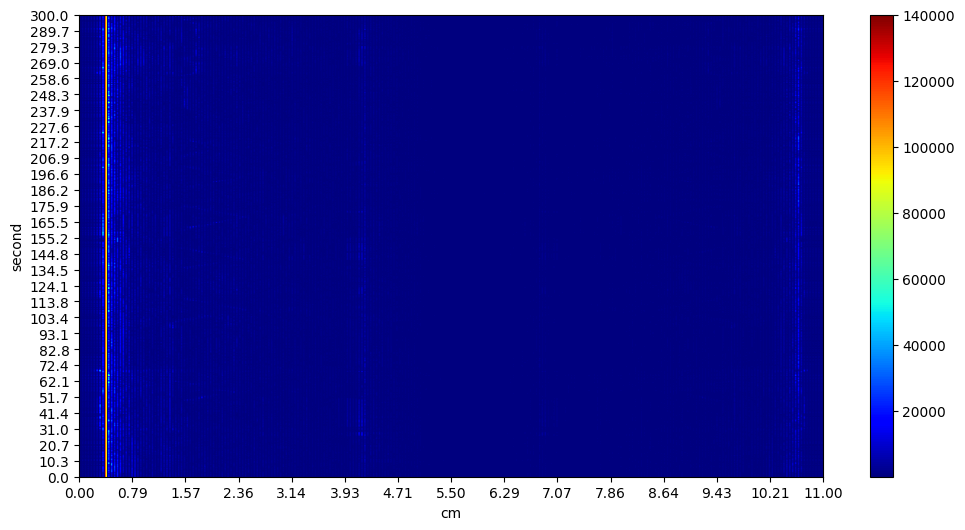

In [108]:
tmp_array= copy.deepcopy(magnitude_corrected_ffts)
for _i,tmp in enumerate(tmp_array):
    tmp[bin_of_interest]=140000
    # tmp[bin_of_interest+1]=140000
    # tmp[bin_of_interest+2]=140000

   

plt.figure(figsize=(12, 6))
xmin=0
xmax=11
x = np.linspace(xmin, xmax, 15)
ymin=0
ymax=len(tmp_array)/20 #6000 chirp ~6000 frame each second has 20 frame -> second
#ymax ~300s ~5mins
print(ymax)
y = np.linspace(ymin, ymax, 30)
plt.xticks(x)
plt.yticks(y)

plt.imshow(tmp_array, cmap='jet', aspect='auto',extent=[xmin,xmax,ymin,ymax])
plt.xlabel('cm')
plt.ylabel('second')
plt.colorbar()
plt.show()

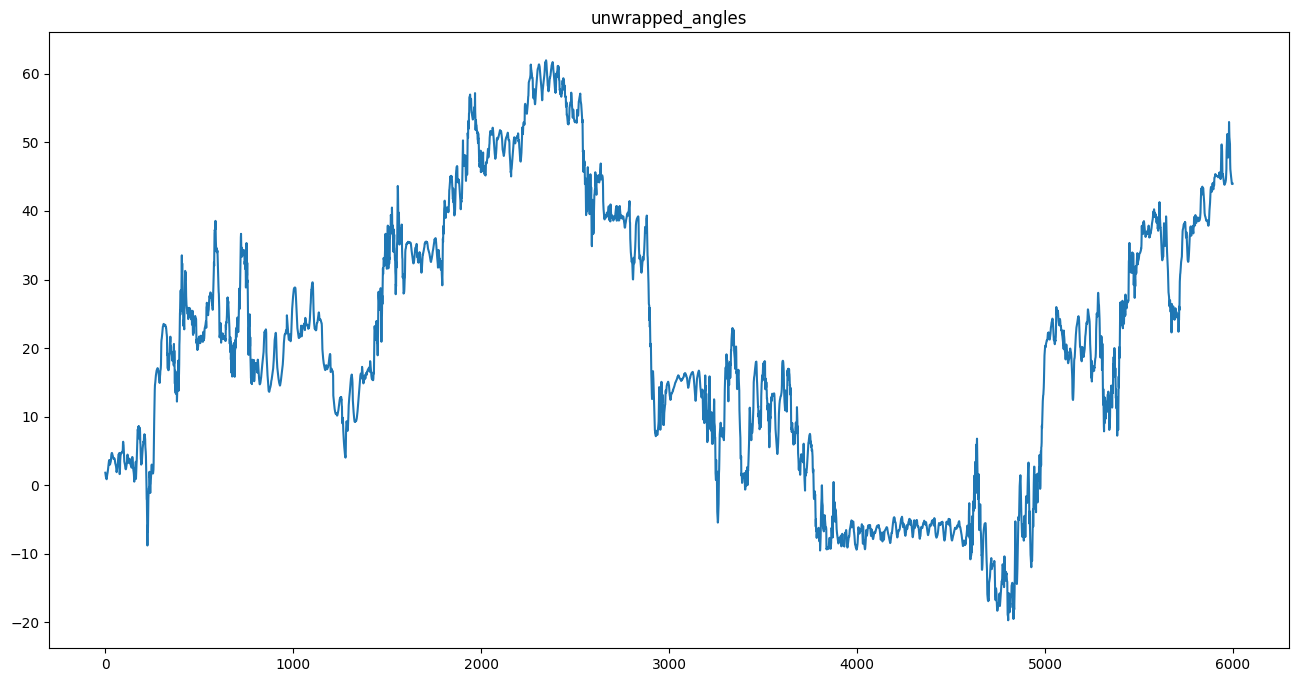

In [232]:
interested_ffts =corrected_range_slow_time_m_x_n[:,bin_of_interest][0:-1]
    
interested_angles = np.angle(np.array(interested_ffts).flatten())
unwrapped_angles=np.unwrap(interested_angles)
plt.figure(figsize=(16,8))
plt.plot(unwrapped_angles)
plt.title("unwrapped_angles")
plt.show()

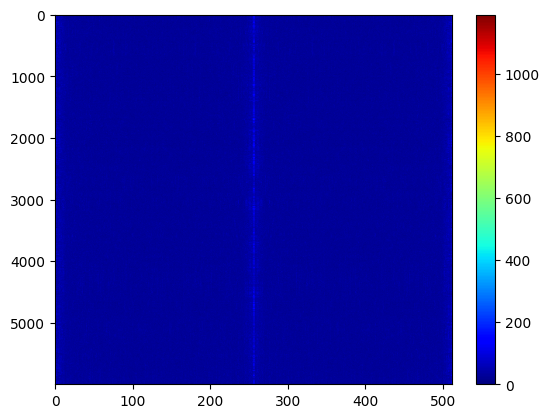

In [131]:
# corrected_angles =[np.angle(corected_range) for corected_range in corrected_range_slow_time_m_x_n]
# corrected_unwraps =[np.angle(corrected_angle) for corrected_angle in corrected_angles]
# corrected_phase_ffts=[np.fft.fft(corrected_unwrap) for corrected_unwrap in corrected_unwraps]
# corrected_phase_mag = [np.abs(corrected_phase_fft) for corrected_phase_fft  in corrected_phase_ffts]
# plt.imshow(corrected_phase_mag,cmap='jet',aspect='auto')
# plt.colorbar()
# plt.show()

In [133]:
unwrapped_corrected_range_slow_time_m_x_n = np.zeros_like(corrected_range_slow_time_m_x_n)
for j_th in range(0,range_bins):
    print("unwrap the ",j_th," bin")   
    unwrapped_corrected_range_slow_time_m_x_n[:,i_th] = np.unwrap(np.angle(corrected_range_slow_time_m_x_n)[:,i_th])

unwrap the  0 th bin
unwrap the  1 th bin
unwrap the  2 th bin
unwrap the  3 th bin
unwrap the  4 th bin
unwrap the  5 th bin
unwrap the  6 th bin
unwrap the  7 th bin
unwrap the  8 th bin
unwrap the  9 th bin
unwrap the  10 th bin
unwrap the  11 th bin
unwrap the  12 th bin
unwrap the  13 th bin
unwrap the  14 th bin
unwrap the  15 th bin
unwrap the  16 th bin
unwrap the  17 th bin
unwrap the  18 th bin
unwrap the  19 th bin
unwrap the  20 th bin
unwrap the  21 th bin
unwrap the  22 th bin
unwrap the  23 th bin
unwrap the  24 th bin
unwrap the  25 th bin
unwrap the  26 th bin
unwrap the  27 th bin
unwrap the  28 th bin
unwrap the  29 th bin
unwrap the  30 th bin
unwrap the  31 th bin
unwrap the  32 th bin
unwrap the  33 th bin
unwrap the  34 th bin
unwrap the  35 th bin
unwrap the  36 th bin
unwrap the  37 th bin
unwrap the  38 th bin
unwrap the  39 th bin
unwrap the  40 th bin
unwrap the  41 th bin
unwrap the  42 th bin
unwrap the  43 th bin
unwrap the  44 th bin
unwrap the  45 th bi

In [182]:
fft_unwrapped_corrected_range_slow_time_m_x_n = np.empty(shape=np.array(unwrapped_corrected_range_slow_time_m_x_n).shape,dtype=complex)
mag_unwrapped_corrected_range_slow_time_m_x_n = np.empty(shape=np.array(unwrapped_corrected_range_slow_time_m_x_n).shape,dtype=float)
for j_th in range(0,range_bins):
    fft_unwrapped_corrected_range_slow_time_m_x_n[:,i_th] = np.fft.fft(unwrapped_corrected_range_slow_time_m_x_n[:,i_th])
    mag_unwrapped_corrected_range_slow_time_m_x_n[:,i_th] =np.abs(fft_unwrapped_corrected_range_slow_time_m_x_n[:,i_th])


In [189]:
mag_unwrapped_indices = np.zeros(shape=len(mag_unwrapped_corrected_range_slow_time_m_x_n))
for  corr_spectrum in mag_unwrapped_corrected_range_slow_time_m_x_n:
    corr_max_index=np.argmax(np.abs(corr_spectrum))
    mag_unwrapped_indices[corr_max_index]+=1
corr_max_bin = max(mag_unwrapped_indices)
corr_bin_of_interest = np.where(corr_max_bin ==mag_unwrapped_indices )[0]

for i,val in enumerate(mag_unwrapped_indices):
    if(0!=val):
        print("index:",i," : ",val)


index: 0  :  0.0
index: 1  :  0.0
index: 2  :  0.0
index: 3  :  0.0
index: 4  :  0.0
index: 5  :  0.0
index: 6  :  0.0
index: 7  :  0.0
index: 8  :  0.0
index: 9  :  0.0
index: 10  :  0.0
index: 11  :  0.0
index: 12  :  0.0
index: 13  :  0.0
index: 14  :  0.0
index: 15  :  0.0
index: 16  :  0.0
index: 17  :  0.0
index: 18  :  0.0
index: 19  :  0.0
index: 20  :  0.0
index: 21  :  0.0
index: 22  :  0.0
index: 23  :  0.0
index: 24  :  0.0
index: 25  :  0.0
index: 26  :  0.0
index: 27  :  0.0
index: 28  :  0.0
index: 29  :  0.0
index: 30  :  0.0
index: 31  :  0.0
index: 32  :  0.0
index: 33  :  0.0
index: 34  :  0.0
index: 35  :  0.0
index: 36  :  0.0
index: 37  :  0.0
index: 38  :  0.0
index: 39  :  0.0
index: 40  :  0.0
index: 41  :  0.0
index: 42  :  0.0
index: 43  :  0.0
index: 44  :  0.0
index: 45  :  0.0
index: 46  :  0.0
index: 47  :  0.0
index: 48  :  0.0
index: 49  :  0.0
index: 50  :  0.0
index: 51  :  0.0
index: 52  :  0.0
index: 53  :  0.0
index: 54  :  0.0
index: 55  :  0.0
in

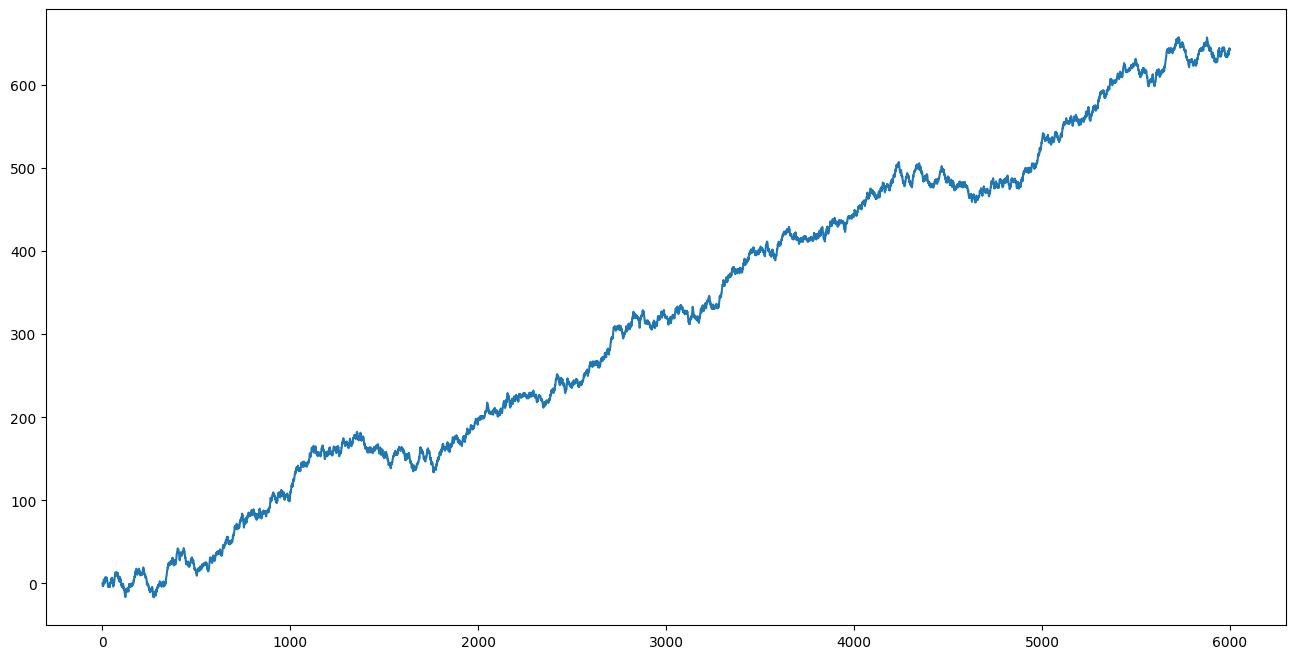

(6000, 512)


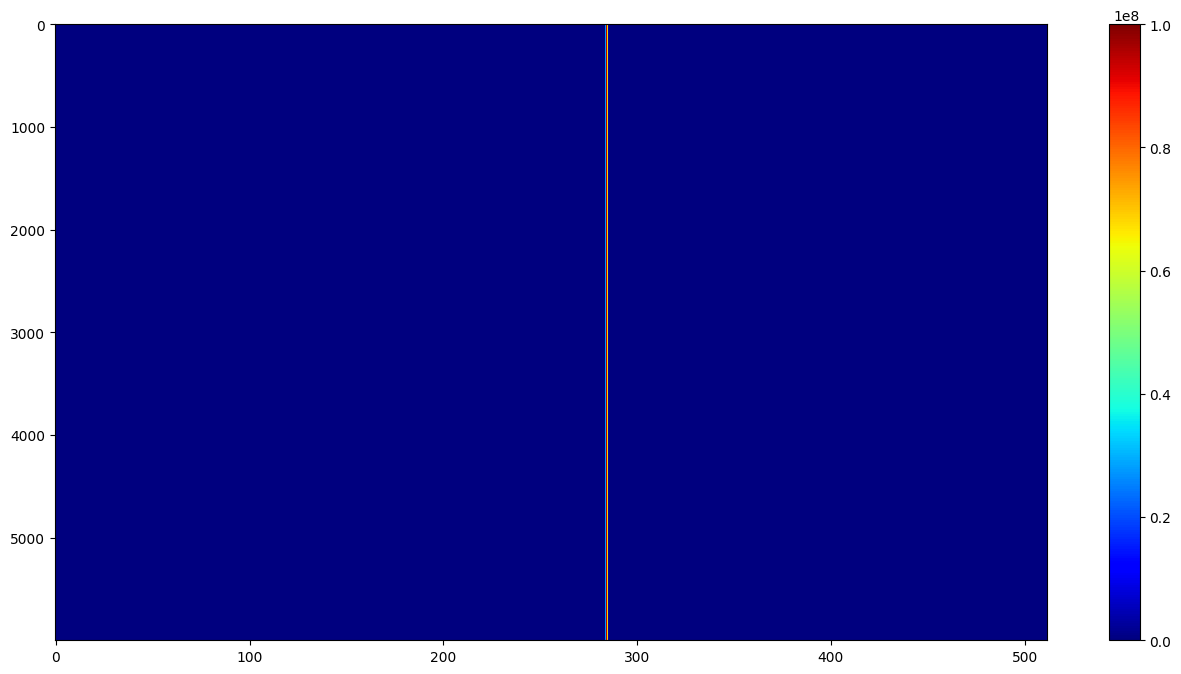

In [243]:
interested_index =corr_bin_of_interest[0]
vital_angles = np.unwrap(np.angle(fft_unwrapped_corrected_range_slow_time_m_x_n[:,interested_index]))
plt.figure(figsize=(16,8))
plt.plot(vital_angles) 
plt.show()
tmp_mag_unwrapped_corrected_range_slow_time_m_x_n = copy.deepcopy(mag_unwrapped_corrected_range_slow_time_m_x_n)
print(tmp_mag_unwrapped_corrected_range_slow_time_m_x_n.shape)

tmp_mag_unwrapped_corrected_range_slow_time_m_x_n[:,interested_index] =1e8

plt.figure(figsize=(16,8))
plt.imshow(tmp_mag_unwrapped_corrected_range_slow_time_m_x_n,cmap='jet',aspect='auto')
plt.colorbar()
plt.show()
